In [1]:
import json
import time
import re
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
# Models for spacy (need to run this from command line if running for the first time)
#!python -m spacy download en_core_web_sm
#!python -m spacy download en_core_web_md
#!python -m spacy download en_core_web_lg
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # to plot word clouds
# Import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
from math import sin, cos, sqrt, atan2, radians
from sklearn.cluster import KMeans
import geopandas as gpd
from collections import Counter

In [2]:
# Loading nlp model 
model = 'en_core_web_lg'
nlp = spacy.load(model)
print("Loaded model '%s'" % model)
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

Loaded model 'en_core_web_lg'


# Functions

In [3]:
def join_to_string(list):
    return ' '.join(list)

def to_text(html):
    # Converts html into text using beautifulSoup
    
    html_doc = "".join(html)
    soup = BeautifulSoup(html_doc, 'html.parser').get_text()
    
    return soup

def remove_stop_words(text):
    doc = nlp(text)
    # all tokens that arent stop words or punctuations (no lemmatization)
    words = [token.text.lower().strip()   
            for token in doc if token.lemma_.lower().strip() not in spacy_stopwords
            and token.is_punct != True
            and token.lemma_.lower().strip() != ""
            and token.lemma_ != "-PRON-"
            and token.lemma_ != "VERB"]
    #print('number of stop words =', sum([token in spacy_stopwords for token in doc]))
    return words

def remove_tokens_like_num(text):
    doc = nlp(text)
    words = [token.text for token in doc if token.like_num != True]
    #print('number of stop words =', sum([token in spacy_stopwords for token in doc]))
    
    return words

def simple_tokenize(text):
    doc = nlp(text)
    # all tokens that arent stop words or punctuations (no lemmatization)
    words = [token.text for token in doc ]
    return words

def lemmatize_words(text):
    doc = nlp(text)
    # all tokens that arent stop words or punctuations (no lemmatization)
    words = [token.lemma_ for token in doc ]
    return words

def extract_skills(tokens, total_skill_set):

    skill_set = set()
    for n, token in enumerate(tokens):
        if token in total_skill_set:
            skill_set.add(token)
        if n < len(tokens)-1:
            if (token + " " + tokens[n+1]) in total_skill_set :
                skill_set.add(token + " " + tokens[n+1])
        if n < len(tokens)-2:
            if (token + " " + tokens[n+1] + " " + tokens[n+2]) in total_skill_set :
                skill_set.add(token + " " + tokens[n+1] + " " + tokens[n+2])
    return skill_set

def compute_sim_matrix(column):
    # Takes a pandas series containing of strings of dimensionality n
    # Outputs a cosine similarity matrix of dimensionality n by n
    
    tfidf_vectorizer = TfidfVectorizer()
    # Tfidf matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform(column)
    # cosine similarity matrix
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    print("tfidf_matrix shape is {}".format(tfidf_matrix.shape))
    print("cosine_sim_shape is {}".format(cosine_sim.shape))
    return cosine_sim

def get_location_state(text):
    # Matches US states abbreviations, if no matches looks for 
    # full state name and returns the abbreviation for it
    pattern = '([A-Za-z]+)?([\W]+)([A-Z]{2})($|[\W])'
#     pattern = '([\W])([A-Z]{2})($|[\W])'
    match = re.search(pattern, text)
    if match:
        return match.group(3)
    else:
        for key, value in states.items():
            if value in text.strip():
                return key
        # if no matches in states dict return None
        return None

def get_location_city(text):
    # Extracts city 
    
    pattern = '([A-Za-z\s\'\.]+)?([\W]+)([A-Z]{2})($|[\W])'
    match = re.search(pattern, text)
    if match:
        return match.group(1)
    else:
        return None

def get_location_zip(text):
    # Matches 5 digit zip code
    
    pattern = '([0-9]{5})'
    match = re.search(pattern, text)
    if match:
        return match.group(1)
    else:
        return None

In [4]:
def calc_distance_between_2_points(lat1_deg, lon1_deg, lat2_deg, lon2_deg):
    """Calculates distance between two points in miles based on latitudes and longitudes"""
    
    # approximate radius of earth in miles
    R = 3958.8
    
    # converting to radians
    lat1_rad = radians(lat1_deg)
    lon1_rad = radians(lon1_deg)
    lat2_rad = radians(lat2_deg)
    lon2_rad = radians(lon2_deg)
    
    # deltas
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad

    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

# print("Result:", calc_distance_between_2_points(52.2296756, 21.0122287, 52.406374, 16.9251681))
# print("Should be:", 278.546*0.621371, "mi")

Loading json file into pandas dataframe:

In [5]:
df = pd.read_json('data_scientist_USA.json', orient='index').reset_index(drop=True)
df['description'] = df['description'].apply(join_to_string)
initial_n = df.shape[0]
print("Read in {} jobs".format(initial_n))
df['company'] = df['company'].apply(str.strip)
df['description'] = df['description'].apply(str.strip)

Read in 7538 jobs


Dropping duplicates coming from sponsored content

In [6]:
df.drop_duplicates(subset ="description", 
                     keep = False, inplace = True)
print("Dropped {} duplicates".format(initial_n - df.shape[0]))
print("Total number of job postings is {}".format(df.shape[0]))

Dropped 1669 duplicates
Total number of job postings is 5869


Dropping NaN

In [7]:
df_clean = df.dropna().reset_index()
print("Final number of job postings is {}".format(df_clean.shape[0]))
del df_clean['id']
del df_clean['index']
print(len(df_clean['company'].unique()))

Final number of job postings is 5869
2895


# Location

In [8]:
# zip codes
df_clean['zip'] = df_clean['location'].apply(get_location_zip)
print("Couldn't find zip codes for {} records".format(sum(df_clean['zip'].isnull())))

Couldn't find zip codes for 3248 records


Reading a dictionary with all american states' abbreviations

In [9]:
with open('states.json') as f:
    states = json.load(f)

In [10]:
# Pulling state abbreviations
df_clean['state'] = df_clean['location'].apply(get_location_state)
print("Couldn't find states for {} records".format(sum(df_clean['state'].isnull())))
# print(df_clean['location'][df_clean['state'].isnull()])

Couldn't find states for 3 records


In [11]:
# pulling city names 
df_clean['city'] = df_clean['location'].apply(get_location_city)
# print(df_clean['city'].unique())
# print(df_clean[['location','city','state']][df_clean['city'].isnull()])
# print("Couldn't find city for {} records".format(len(df_clean[df_clean['city'].isnull()])))
print(df_clean[df_clean['city'].isnull()].index)
df_clean['location'][41]

Int64Index([  13,   34,   41,   42,  127,  140,  364,  445,  818,  826, 1126,
            1147, 1226, 1660, 1668, 1794, 1930, 2007, 2022, 2307, 2330, 2385,
            2407, 2555, 2704, 2751, 2820, 3238, 3618, 3619, 3762, 3856, 3868,
            3915, 3959, 3960, 4104, 4308, 4317, 4327, 4343, 4379, 4774, 4891,
            5061, 5062, 5651, 5665, 5718, 5748],
           dtype='int64')


'Massachusetts'

In [12]:
# # List of all american cities by state (downloaded from https://simplemaps.com/data/us-cities)
cities_list = pd.read_csv('uscities.csv')

cities = cities_list[['city', 'state_id', 'lat', 'lng', 'zips']]
merged_df = df_clean.merge(cities, how='left', left_on=['city', 'state'], right_on=['city', 'state_id'])
del merged_df['state_id']
# can also match ZIP code from scraped data where available with list of zips in cities_list

In [14]:
# mo = cities[(cities['state_id'] == 'MO')]
# for index, row in mo.iterrows():
#     print(row['city'])

In [15]:
print("{} cities are without coordinates".format(sum(merged_df['lat'].isnull())))
merged_df[(merged_df['state'] == 'MO')].sample(10)
# merged_df[merged_df['lat'].isnull()].sample(10)

497 cities are without coordinates


,company,description,link,location,title,zip,state,city,lat,lng,zips
2130,"Noise Consulting Group, Inc",Job Summary Position: Data ScientistLocation: ...,https://www.indeed.com/company/Noise-Consultin...,"Saint Charles, MO",Data Scientist,None,MO,Saint Charles,NaN,NaN,NaN
5642,Washington University in St. Louis,Job Type/Schedule \n \n \n \n This position is...,https://www.indeed.com/rc/clk?jk=d0b7e2de31445...,"St. Louis, MO",Statistical Data Analyst - Pediatrics Critical...,None,MO,St. Louis,38.6358,-90.2451,63110 63111 63112 63113 63115 63116 63118 6312...
1466,Centene Corporation,Responsible for advanced and predictive data a...,https://www.indeed.com/rc/clk?jk=cdc7fd50c9922...,"Clayton, MO 63105",Data Scientist I,63105,MO,Clayton,38.6444,-90.3303,63105 63195 63199
5451,Leidos,Description \n Job Description: \nLeidos is se...,https://www.indeed.com/rc/clk?jk=a13f0d5058e61...,"St. Louis, MO 63132",Sr. Data Scientist - TS/SCI Required,63132,MO,St. Louis,38.6358,-90.2451,63110 63111 63112 63113 63115 63116 63118 6312...
5012,Trusted Knowledge Options Inc.,Background : \nThe Geolock program's goal is d...,https://www.indeed.com/rc/clk?jk=7614c28ed7197...,"St. Louis, MO 63101",Senior Scientist Geomatics / Geolock / Foundat...,63101,MO,St. Louis,38.6358,-90.2451,63110 63111 63112 63113 63115 63116 63118 6312...
980,Centene Corporation,Position Responsibilities: \nWrite software co...,https://www.indeed.com/rc/clk?jk=467c95511e2f2...,"St. Louis, MO",Data Science Engineer I,None,MO,St. Louis,38.6358,-90.2451,63110 63111 63112 63113 63115 63116 63118 6312...
2764,Bayer,Your tasks and responsibilities \n The primary...,https://www.indeed.com/rc/clk?jk=c99ab430a5218...,"Creve Coeur, MO",Field Innovation Data Science Lead,None,MO,Creve Coeur,38.6621,-90.4430,63141 63167
2267,DST Systems,Company Overview\n SS&C is a global provider o...,https://www.indeed.com/rc/clk?jk=b23645540137b...,"Kansas City, MO",Data Scientist,None,MO,Kansas City,39.1239,-94.5541,64161 64163 64165 64167 64053 64151 64153 6415...
1941,Ameren,DATA SCIENTIST (ZA7615) \n \nAbout The Positi...,https://www.indeed.com/rc/clk?jk=45249d9d84bb9...,"St. Louis, MO",Data Scientist,None,MO,St. Louis,38.6358,-90.2451,63110 63111 63112 63113 63115 63116 63118 6312...
5614,"Eurofins BioPharma Product Testing Columbia, Inc.","Staff Scientist, Data Review-QA \n \nEurofins ...",https://www.indeed.com/rc/clk?jk=09ccdfbf2bf80...,"Columbia, MO","Staff Scientist, Data Review - QA",None,MO,Columbia,38.9477,-92.3255,65202 65203 65201 65215 65211 65216 65217 6521...


<IPython.core.display.Javascript object>


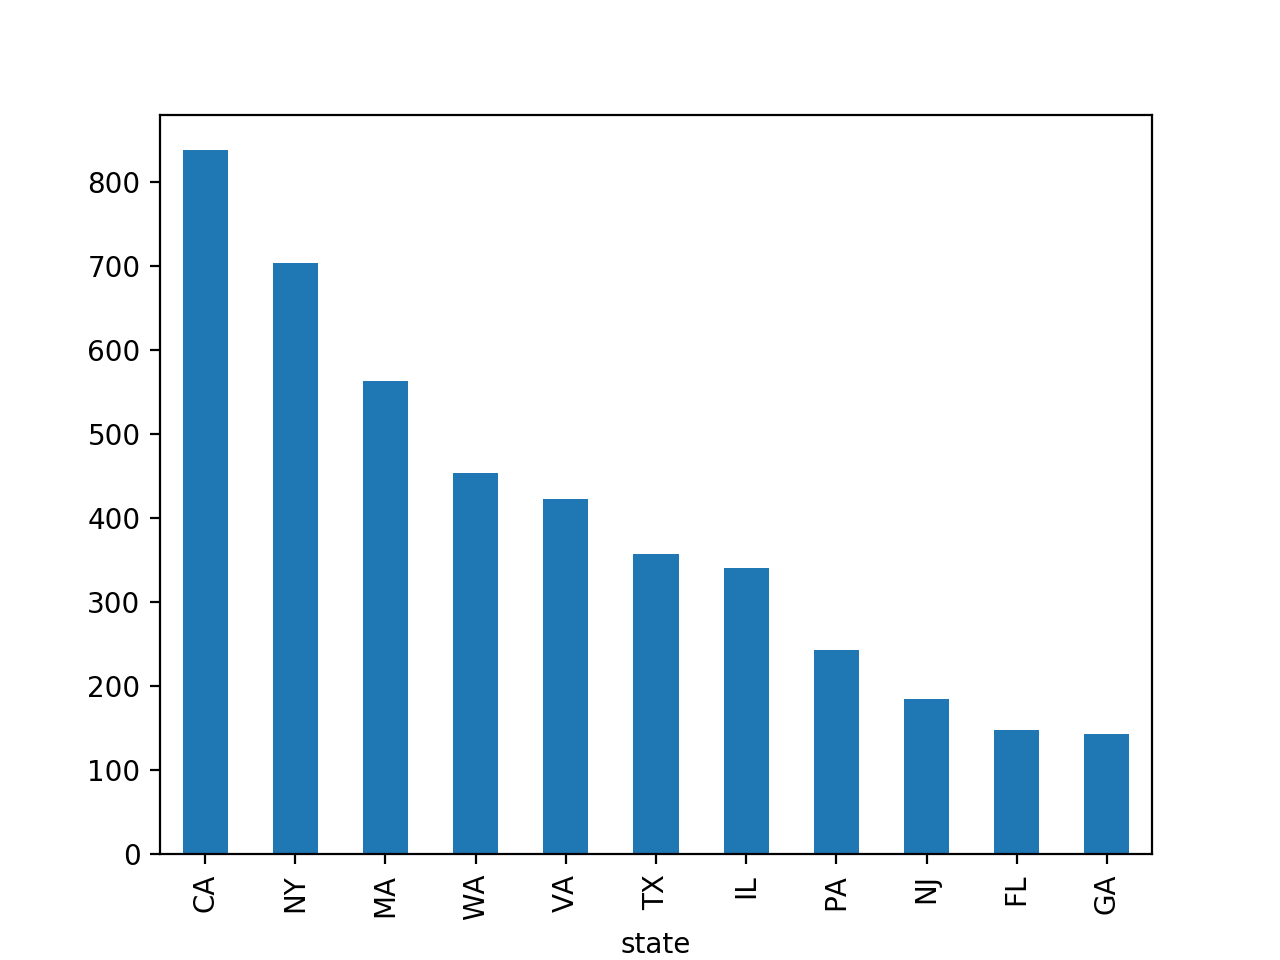

In [16]:
%matplotlib notebook
# Number of positions by state
n_pos_by_state = merged_df.groupby('state')['state'].count().sort_values(ascending=False)
# print("Top 10 states hiring in the field:\n", n_pos_by_state[:11])
n_pos_by_state[:11].plot(kind='bar')

# WordCloud

In [ ]:
words_for_wordcloud = merged_df['description'].apply(simple_tokenize)

In [ ]:
total_list_of_words =' '.join([item for words in words_for_wordcloud for item in words])

In [ ]:
# Wordcloud for requirements
wordcloud = WordCloud(background_color='white',
        stopwords=set(STOPWORDS),
        max_words=200,
        max_font_size=40, 
        scale=3, collocations=True).generate(total_list_of_words)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [109]:
%matplotlib notebook
# Number of positions by state
n_pos_by_company = merged_df.groupby('company')['state'].count().sort_values(ascending=False)
print("Top 20 companies hiring in the field:\n", n_pos_by_company[:21])
# n_pos_by_company[:11].plot(kind='bar')
# should take into account different variations of company names

Top 20 companies hiring in the field:
 company
Amazon.com Services, Inc.                177
Apple                                    109
Facebook                                  89
Booz Allen Hamilton                       52
Microsoft                                 43
Capital One - US                          41
JP Morgan Chase                           37
Amazon Web Services, Inc.                 33
Spotify                                   28
Walmart                                   25
IBM                                       24
Twitter                                   22
NVIDIA                                    19
SAIC                                      18
The Home Depot                            18
Mitre Corporation                         18
Nielsen                                   18
Johnson & Johnson Family of Companies     17
Oracle                                    17
AbbVie                                    17
Allstate                                  17
Name: st

In [110]:
def filter_by_loc(df, cities, city_of_interest, state, radius):
    """Filters jobs by location within a certain radius
    Inputs:
    Dataframe with job postings
    Dataframe cities with coordinates for cities
    City of interest
    State
    Radius"""
    
    # check if such state exists
    assert state in cities['state_id'].unique(), "No such state in the United States"
    # check if such a city exists in the provided state
    assert city_of_interest in cities[cities['state_id'] == state]['city'].unique(), "No such city in requested state"
    # pulling row for the city we need to extract coordinates
    city_row = cities[(cities['state_id'] == state) & (cities['city'] == city_of_interest)]
    lat = city_row['lat']
    long = city_row['lng']
    within_radius = []
    for index, row in df.iterrows():
        # distance between desired city and the city  in each row
        distance = calc_distance_between_2_points(lat, long, row['lat'], row['lng'])
        # boolean array to filter dataframe to get the cities we need
        within_radius.append(distance < radius)
    
    return df[within_radius]


In [111]:
# df_plot = merged_df[~merged_df['state'].isnull()]
# df_plot = df_plot[['state', 'city', 'lat', 'lng']]
n_pos_by_state
df_n_pos_by_state = n_pos_by_state.to_frame(name='n_pos')
df_n_pos_by_state.reset_index(inplace=True)
df_n_pos_by_state.head()

,state,n_pos
0,CA,837
1,NY,703
2,MA,563
3,WA,453
4,VA,423


In [112]:
geo_df = gpd.read_file('/Users/Dmitry/Downloads/JobMarketAnalysis/US_shape/tl_2017_us_state.shp')
geo_df.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62265662566,489840834,+38.6472854,-080.6183274,"POLYGON ((-81.74725 39.09538, -81.74635 39.096..."
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138911437206,31398800291,+28.4574302,-082.4091478,"MULTIPOLYGON (((-82.98748 24.62538, -82.98748 ..."
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143784114293,6211277447,+40.1028754,-089.1526108,"POLYGON ((-91.18529 40.63780, -91.17510 40.643..."
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206229176104,18944967530,+46.3158148,-094.1996628,"POLYGON ((-96.78438 46.63050, -96.78434 46.630..."
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25150696145,6980371026,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220..."


In [113]:
merged_geo_df = geo_df.merge(df_n_pos_by_state, how='inner', left_on=['STUSPS'], right_on=['state'])
merged_geo_df.head()

,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,state,n_pos
0,3,5,54,01779805,54,WV,West Virginia,00,G4000,A,62265662566,489840834,+38.6472854,-080.6183274,"POLYGON ((-81.74725 39.09538, -81.74635 39.096...",WV,6
1,3,5,12,00294478,12,FL,Florida,00,G4000,A,138911437206,31398800291,+28.4574302,-082.4091478,"MULTIPOLYGON (((-82.98748 24.62538, -82.98748 ...",FL,148
2,2,3,17,01779784,17,IL,Illinois,00,G4000,A,143784114293,6211277447,+40.1028754,-089.1526108,"POLYGON ((-91.18529 40.63780, -91.17510 40.643...",IL,341
3,2,4,27,00662849,27,MN,Minnesota,00,G4000,A,206229176104,18944967530,+46.3158148,-094.1996628,"POLYGON ((-96.78438 46.63050, -96.78434 46.630...",MN,82
4,3,5,24,01714934,24,MD,Maryland,00,G4000,A,25150696145,6980371026,+38.9466584,-076.6744939,"POLYGON ((-77.45881 39.22027, -77.45866 39.220...",MD,95


<IPython.core.display.Javascript object>


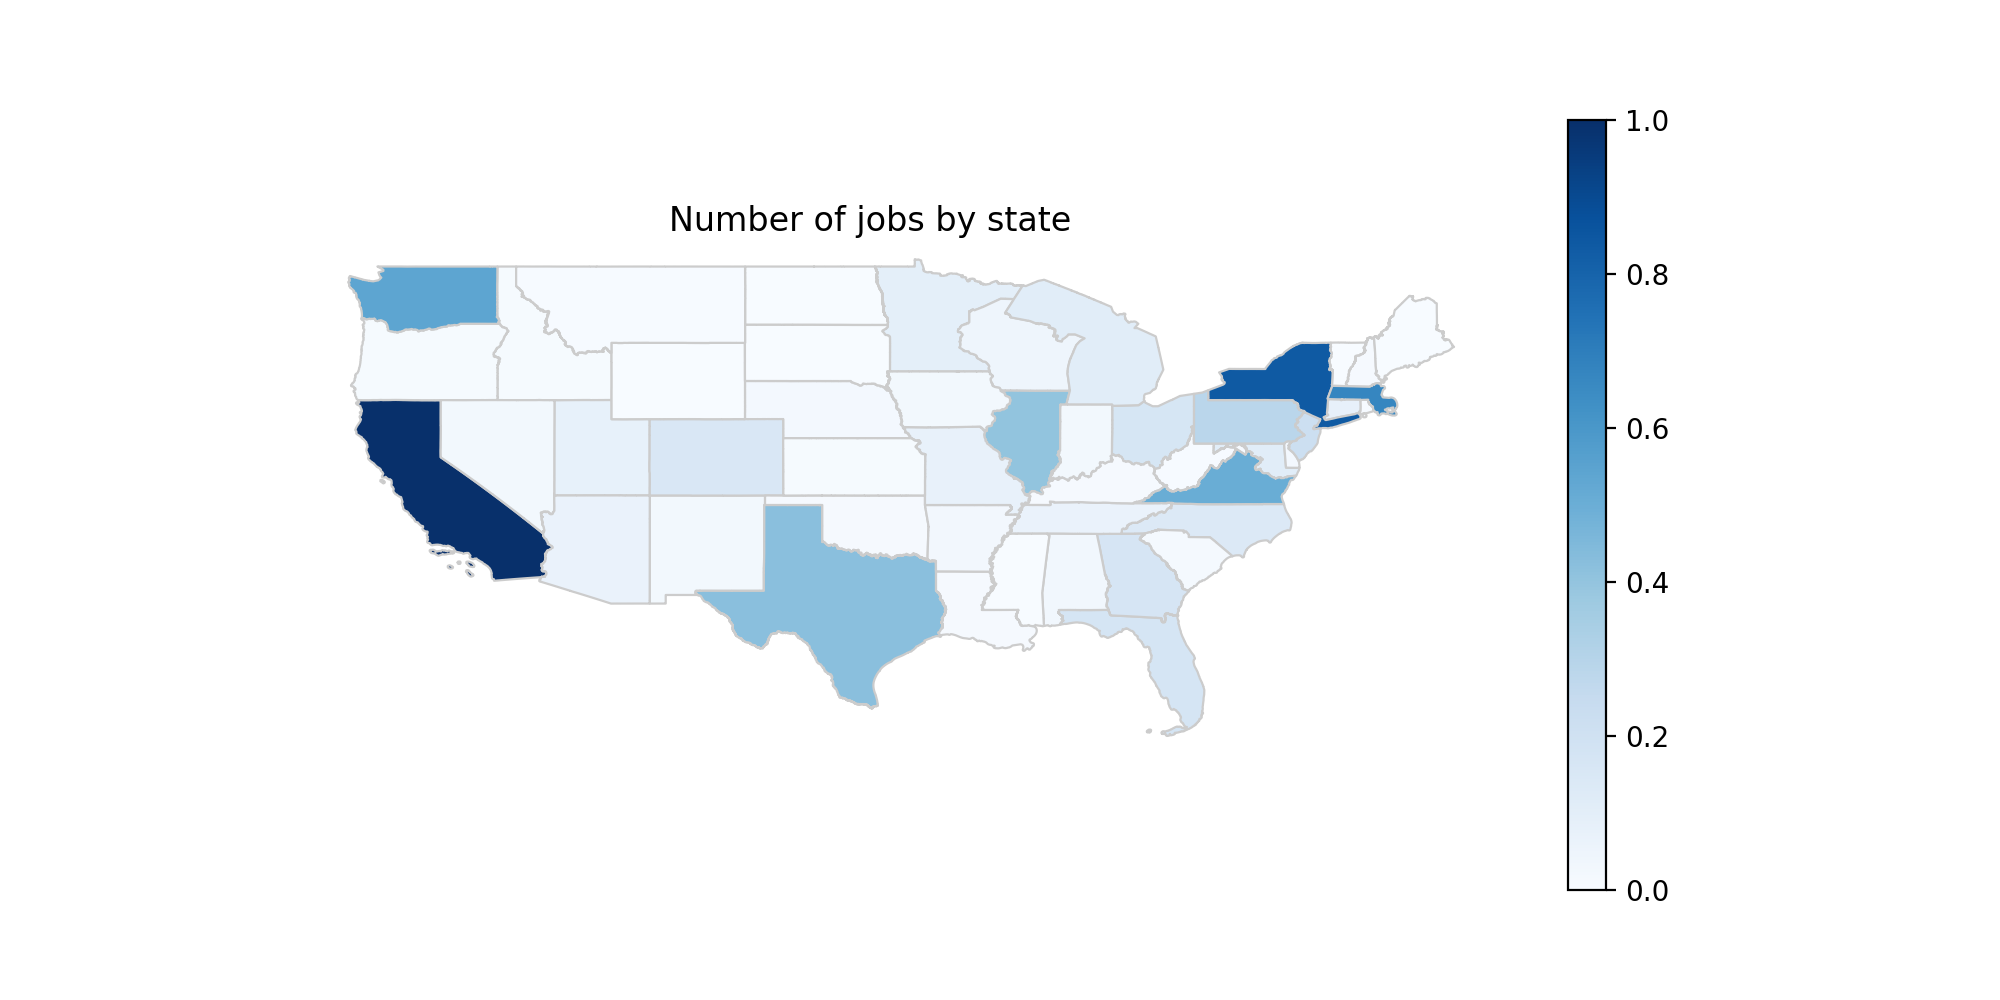

In [130]:
%matplotlib notebook
merged_geo_df.plot(column='n_pos', cmap='Blues', linewidth=0.8, edgecolor='0.8', figsize=(10,5))
plt.xlim([-130, -65])
plt.ylim([23, 50])
plt.axis('off')
plt.title("Number of jobs by state")
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues')
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = plt.colorbar(sm)

# Skills

Here assembling a set of skills that show up in job applications, going to use it as one of the matching criteria
this list of skills is from data.world. There is still a lot of junk, should find a better option.

In [115]:
# skills_new = pd.read_csv("skills.csv")
# total_skill_set = set(skills_new['name'])
# total_skill_set = set([skill.lower() for skill in total_skill_set])
# skills_new.shape[0]

28934

In [ ]:
# Skills from kaggle dataset https://www.kaggle.com/elroyggj/indeed-dataset-data-scientistanalystengineer/data

In [152]:
ds_indeed = pd.read_csv("/Users/Dmitry/Downloads/JobMarketAnalysis/indeed-dataset-data-scientistanalystengineer/indeed_job_dataset.csv")

In [257]:
import ast
import math
total_skill_set = set()
for skill_list in ds_indeed['Skill'][~ds_indeed['Skill'].isnull()]:
    skill_list = ast.literal_eval(skill_list)
#     print(skill_list, len(skill_list), type(skill_list))
    if len(skill_list) > 1:
        for skill in skill_list:
            total_skill_set.add(skill)
#                 print (skill)
    else: 
        total_skill_set.add(skill_list[0])


total_skill_set = set([skill.lower() for skill in total_skill_set])
print(total_skill_set)

False


Tfidf vectorizer and cosine similarity matrix

In [254]:
countvec = TfidfVectorizer(ngram_range=(1, 3), vocabulary=total_skill_set, min_df=5, max_df=0.95)
# countvec = TfidfVectorizer(ngram_range=(1, 3), vocabulary=total_skill_set)

countvec.fit(merged_df['description'])
skills_vec = countvec.transform(merged_df['description'])
cosine_sim = cosine_similarity(skills_vec, skills_vec)

Creating list of skills with nonzero weight in tfidf vector

In [255]:
columns = np.asarray(countvec.get_feature_names())
skills_array = skills_vec.toarray()
skills_column = [columns[skills_array[n].astype(bool) == True] for n in range(len(skills_array))]

# adding lists of skills to dataframe 
merged_df['skills'] = skills_column
merged_df['skills'].head()

0    [big data, data analysis, data mining, data sc...
1                             [python, scala, tableau]
2                             [python, scala, tableau]
3    [big data, business intelligence, machine lear...
4    [azure, business intelligence, data mining, go...
Name: skills, dtype: object

<IPython.core.display.Javascript object>


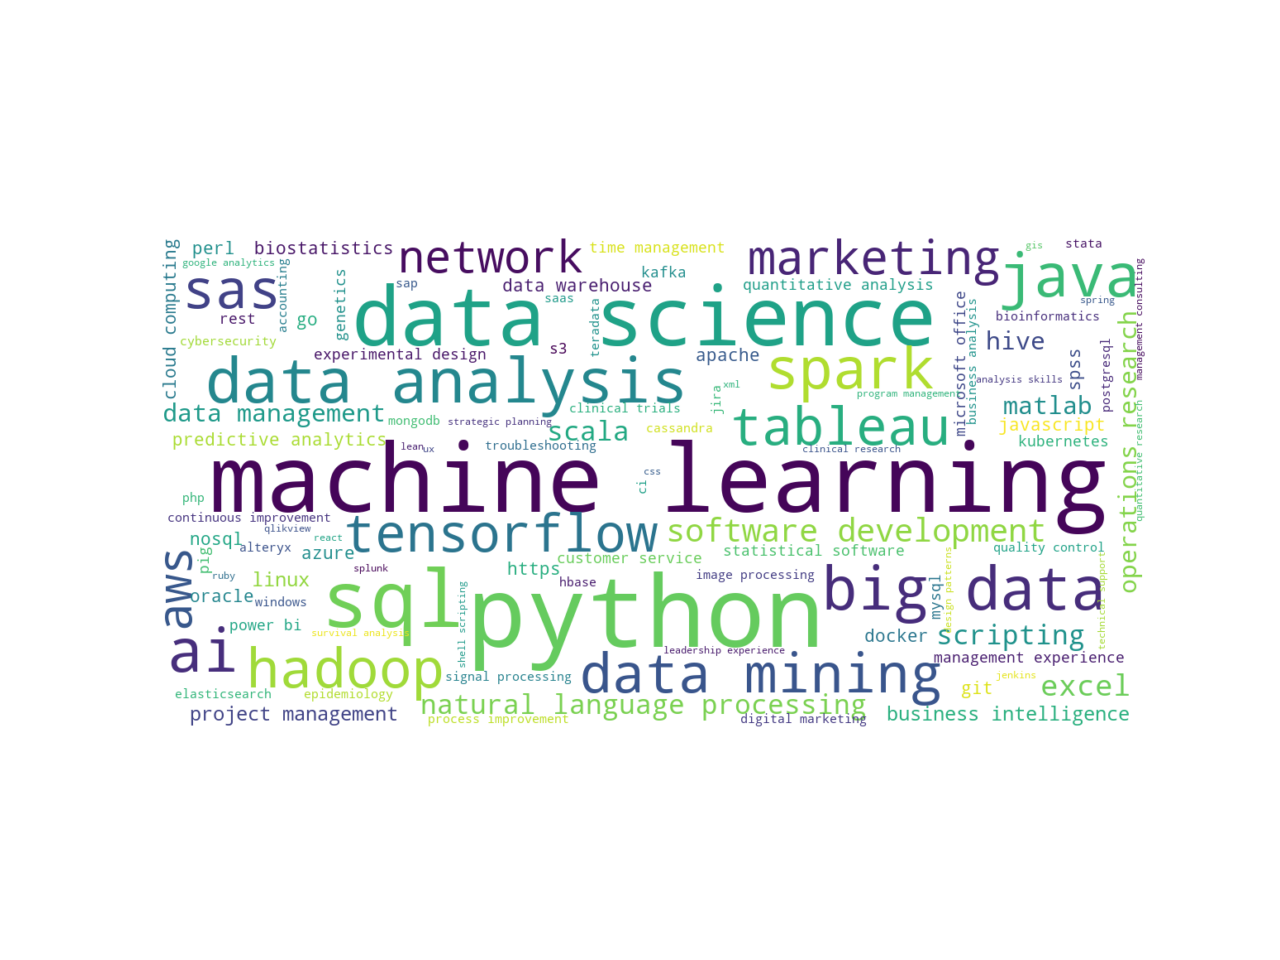

In [267]:
total_list_of_skills =' '.join([item.strip() for words in skills_column for item in words])
# print([item.strip() for words in skills_column for item in words])
# Wordcloud for requirements
word_could_dict=Counter([item.strip() for words in skills_column for item in words])
wordcloud = WordCloud(background_color='white',
        stopwords=set(STOPWORDS),
        max_words=200,
        max_font_size=40, 
        scale=3, collocations=True).generate_from_frequencies(word_could_dict)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Recommendations based on cosine similarity constructed from tfidf vector using skills vocabulary, not the whole job description. Vocabulary is trivial to modify

In [118]:
def get_recommendations(df, title, cosine_sim):
    
    # series of indices indexed by "title"
    indices = pd.Series(df.index, index=df['title']).drop_duplicates()
    # Get index of job that matches title
    idx = indices[title]
    # Sort the jobs based on the similarity scores
    scores = list(enumerate(cosine_sim[idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    # Get the scores for 10 most similar jobs
    scores = scores[1:21]
    # Get the indices
    job_indices = [i[0] for i in scores]
    # Return the top 10 most similar jobs
    return df['title'].iloc[job_indices]

index = 3
job = merged_df['title'][index]
rec = get_recommendations(merged_df, job, cosine_sim)
print("Recommendations for: {}\n".format(job))
for index_2, line in rec.iteritems():
    print("{}. Similarity: {}".format(line, cosine_sim[index, index_2]))


Recommendations for: (2) Senior Data Scientist - (Machine Learning, R, Python) (62398BR)

Machine Learning Modeler - CT. Similarity: 0.6448498875907215
Lead Data Scientist- 63246BR. Similarity: 0.5599149034987654
Lead Data Scientist - Clinical - 65343BR. Similarity: 0.5220372301064783
STATISTICIAN II. Similarity: 0.39982049468301833
Lead Data Scientist - 61282BR. Similarity: 0.3808017593509256
Data Scientist. Similarity: 0.35739164177580696
Data Scientist I-III. Similarity: 0.3418109115920843
Sr Data Scientist. Similarity: 0.33170332984184847
Data Scientist – Organizational Performance. Similarity: 0.33122014262265165
Data Scientist. Similarity: 0.32681068870677255
Principal Data Scientist. Similarity: 0.31922168454305044
Associate Director, Advanced Analytics & Data Science. Similarity: 0.31705516007876977
Data Scientist. Similarity: 0.3166961628456476
Sr. Dir. Data Science – Clinical Stratification - 63725BR. Similarity: 0.31616257800998465
Data Scientist (Alpharetta). Similarity: 0.

# Number of matching skills with provided resume

In [251]:
# Extracting data from resume text file
file = 'resume.txt'
with open(file) as open_file:
    resume = open_file.read().lstrip()
my_skills = extract_skills(remove_stop_words(resume), total_skill_set)
print("List of skills matched with the full list of skills:\n\n", my_skills)

List of skills matched with the full list of skills:

 {'data analysis', 'software development', 'sql', 'eclipse', 'svn', 'matlab', 'linux', 'git', 'data science', 'r', 'python', 'fortran'}


In [252]:
# Creating list of matched skills from resume with each job posting
match_skills = []
for index, skills in enumerate(skills_column):
    overlap = my_skills.intersection(set(skills))
    match_skills.append((index, len(overlap)))
# sorting by the number of matches
sorted_skills = sorted(match_skills, key=lambda elem: elem[1], reverse=True)

# Printing top 5 jobs with largest intersection of skills
for index, n_matches in sorted_skills[:5]:
    print("\n", merged_df['title'][index])
    print(my_skills.intersection(skills_column[index]))


 Data Science Researcher I/II Dayton, OH - ACL
{'data analysis', 'software development', 'sql', 'python', 'linux', 'git', 'data science', 'matlab'}

 Data Engineer, National Robotics Engineering Center (NREC)
{'data analysis', 'software development', 'sql', 'python', 'linux', 'data science', 'matlab'}

 Data Scientist, Growth Data Science
{'data analysis', 'software development', 'sql', 'linux', 'git', 'data science', 'python'}

 Senior AI Engineer (Machine Learning)
{'data analysis', 'software development', 'sql', 'python', 'linux', 'data science', 'matlab'}

 Sr. Associate, Data Scientist Optimization
{'data analysis', 'software development', 'python', 'svn', 'git', 'data science', 'matlab'}


# Classification of titles

In [121]:
# removing stop words
title_column = merged_df['title'].apply(remove_stop_words).apply(join_to_string)

In [122]:
# removing numberS
title_column = title_column.apply(remove_tokens_like_num).apply(join_to_string)

In [250]:
doc1 = nlp(title_column[0])
doc2 = nlp(title_column[1])
print(doc1)
print(title_column[32])

sr data scientists
summer internship bank supervision data science


In [123]:
# vectorizing titles, keeping only features that are seen in at least 1% of titles
titles_vectorizer = TfidfVectorizer(ngram_range=(1, 1), min_df=0.01)
titles_vectorizer.fit(title_column)
title_vec = titles_vectorizer.transform(title_column)
terms = titles_vectorizer.get_feature_names()
print("Number of features: {}".format(title_vec.shape[1]))
print("Feature names:\n{}".format(terms))

Number of features: 42
Feature names:
['ai', 'analyst', 'analytics', 'applied', 'architect', 'artificial', 'associate', 'business', 'computer', 'data', 'deep', 'developer', 'development', 'director', 'engineer', 'engineering', 'ii', 'intelligence', 'intern', 'internship', 'lead', 'learning', 'machine', 'manager', 'ml', 'modeling', 'nlp', 'principal', 'product', 'programmer', 'research', 'researcher', 'science', 'scientist', 'senior', 'software', 'specialist', 'sr', 'statistical', 'statistician', 'summer', 'vision']


In [124]:
k = 10
model = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=2)
model.fit(title_vec)
# vector of cluster labels
labels = model.predict(title_vec)
# looking at elements in clusters
first_cluster = (labels == 3)
print(title_column[first_cluster].sample(10))

3144                          machine learning algorithms
3360                              machine learning intern
2903                  intern development machine learning
3362            machine learning junior software engineer
3232                            machine learning engineer
3291                            machine learning engineer
3275                            machine learning engineer
3654    post doctoral fellow machine learning computer...
3127                machine learning ml engineer- core ml
3294                            machine learning engineer
Name: title, dtype: object


<IPython.core.display.Javascript object>


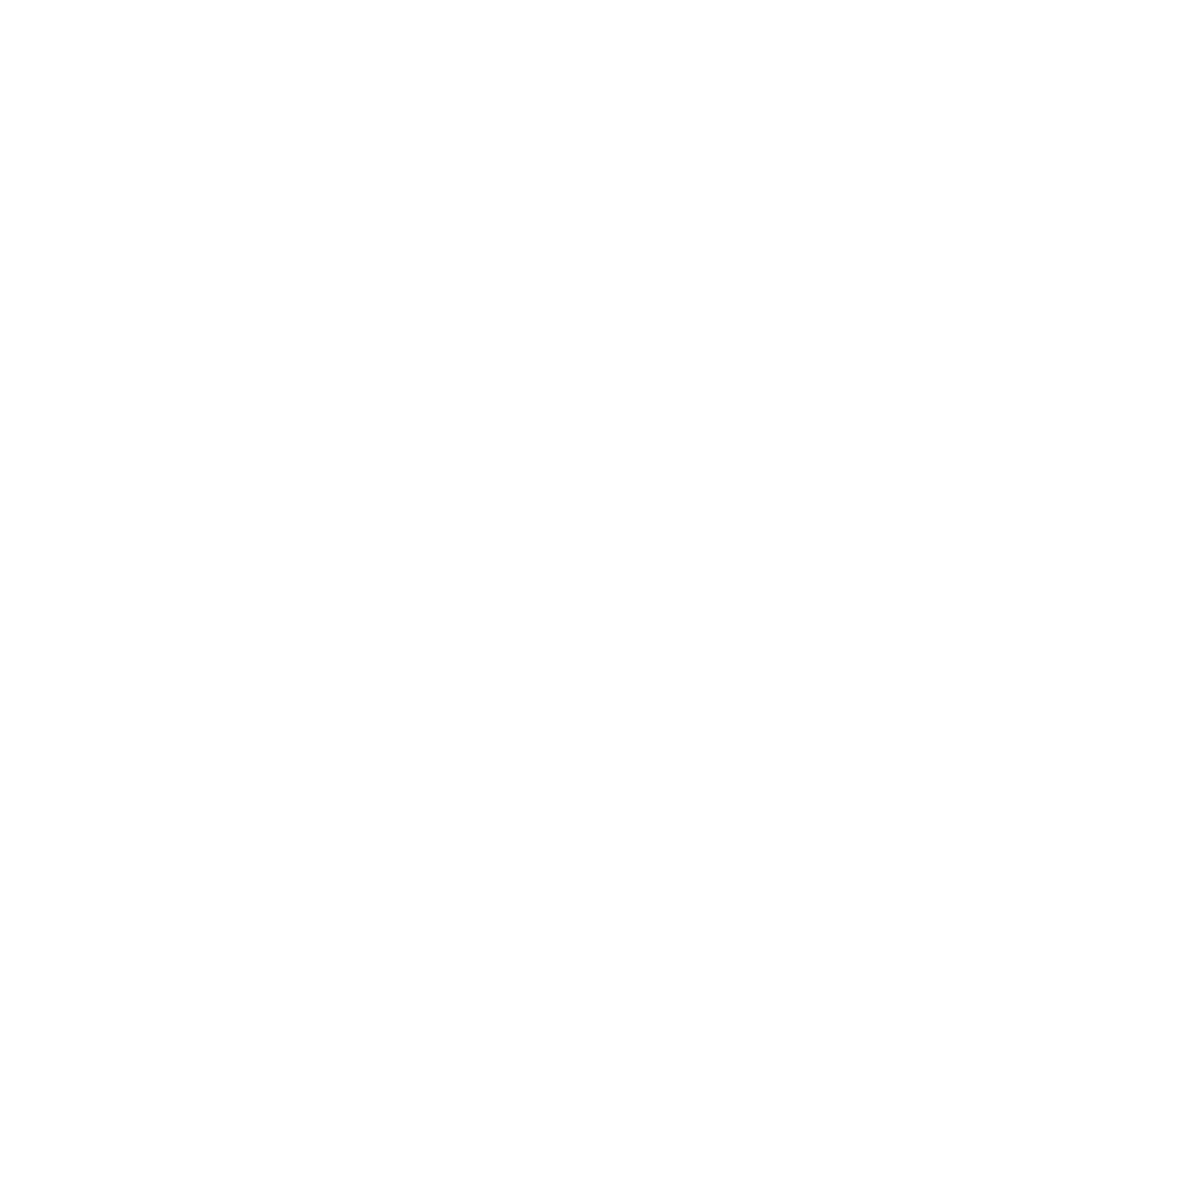

Text(0, 0.5, 'Sum of squared distance')

In [125]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(title_vec)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

In [126]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
for i in range(k):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 analyst
 senior
 data
 statistical
 business
 scientist
 research
 modeling
 associate
 science
Cluster 1:
 engineer
 scientist
 data
 ai
 lead
 computer
 research
 vision
 principal
 associate
Cluster 2:
 scientist
 data
 engineer
 computer
 ai
 associate
 intern
 architect
 artificial
 applied
Cluster 3:
 learning
 machine
 engineer
 software
 scientist
 senior
 research
 data
 deep
 ai
Cluster 4:
 senior
 scientist
 data
 engineer
 applied
 principal
 lead
 nlp
 product
 science
Cluster 5:
 statistician
 research
 principal
 senior
 scientist
 data
 sr
 analyst
 lead
 manager
Cluster 6:
 science
 data
 director
 intern
 engineer
 analyst
 lead
 internship
 summer
 software
Cluster 7:
 manager
 science
 data
 analytics
 product
 senior
 machine
 learning
 sr
 statistical
Cluster 8:
 sr
 analyst
 data
 scientist
 business
 applied
 science
 engineer
 associate
 analytics


# Education (in progress)

In [127]:
intern = ['freshman', 'sophomore', 'junior', 'internship']
higher_ed = ['bs', 'bachelor', 'bachelors', 'bachelor\'s', 'degree']
masters_degree = ['master\'s', 'masters', 'master', 'ms', 'graduate', ]
phd = ['phd', 'ph.d.', 'doctorate', 'doctoral']
def find_ed_sent(text):
    doc = nlp(text)
    for sent in doc.sents:
        for token in sent:
            if token.text.lower() in intern: print("INTERN\n", sent)
            if token.text.lower() in higher_ed: print("HIGHER ED\n", sent)
            if token.text.lower() in masters_degree: print('MASTERS\n', sent)
            if token.text.lower() in phd: print('PHD\n', sent)

find_ed_sent(to_text(df_clean['description'].iloc[36]))
# print(to_text(df_clean['description'].iloc[25]))

HIGHER ED
 Pursuing a Bachelor’s or Master’s degree in Computer Science, Analytics, Data Science, Engineering, Mathematics, or equivalent field of study
 
Graduating in Winter 2019 or Spring/Summer 2020
 
 
MASTERS
 Pursuing a Bachelor’s or Master’s degree in Computer Science, Analytics, Data Science, Engineering, Mathematics, or equivalent field of study
 
Graduating in Winter 2019 or Spring/Summer 2020
 
 
HIGHER ED
 Pursuing a Bachelor’s or Master’s degree in Computer Science, Analytics, Data Science, Engineering, Mathematics, or equivalent field of study
 
Graduating in Winter 2019 or Spring/Summer 2020
 
 
INTERN
 Preferred: 
A minimum cumulative GPA of 3.0 on a 4.0 scale
 
Previous internship or co-op participant in related industry
 
Previous internship with Phillips 66
 
Phillips 66 SHIELD Scholar recipient
 
Willing to work in any of our operating locations
 
Proficiency in R or Python and familiarity with data science packages in that language
 
Understanding of Computer Scie

# Experience (in progress)

In [128]:
def find_exp(text):
    exp_id = []
    num_id = []
    year_id = []
    sents = []
    doc = nlp(text)
    for sent in doc.sents:
        for token in sent:
            if token.text.lower() == 'experience':
                exp_id.append(token.i)
            
            if token.lemma_ == 'year':
                year_id.append(token.i)
                for token_num in doc[token.i-2:token.i]:
                    if token_num.like_num:
                        print("SENT:", sent)
                        num_id.append(token_num.i)
#     for id in exp_id: print(doc[id])
    for id in num_id: print(doc[id])
    for id in year_id: print(doc[id])
#     print(num_id)
#     print(year_id)
#     print(exp_id)
#     print(doc[337:359])

In [129]:
sent = find_exp(merged_df['description'].iloc[40])
print("\n", merged_df['description'].iloc[40])

SENT: 5+ years of SAS programming working with clinical trial data in the Pharmaceutical & Biotech industry. 

5
years

 As a leader in next generation, data-driven pharmaceutical services, Cytel is shaping the future of drug development. We deliver to the market innovative analytical software for statistical analysis and simulation, best-in-class data science analytics services and high-end impact consulting. Our culture is inclusive, collaborative and results-driven with a shared commitment to quality. With operations across North America, Europe, and India, Cytel hires passionate and talented people who share its mission of ensuring the clinical development of safe and effective medicines. 
 
We are experiencing exponential growth on a global scale and hiring Statistical Programmers to join our FSP division. You will support Phase I-IV clinical trials across a variety of therapeutic areas, and report to the Associate Director, Statistical Programming. 
 
This is a home-based positio